In [9]:
%reset

In [10]:
#Imports
import numpy as np
import cobra as cb
import pandas as pd
import matplotlib.pyplot as plt
from cobra import Model, Reaction, Metabolite

In [11]:
#Load the base genome model

EC_model_eng = cb.io.load_matlab_model("iML1515.mat")
EC_model_eng

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Name,iML1515
Memory address,17ac9dfac10
Number of metabolites,1877
Number of reactions,2712
Number of genes,1516
Number of groups,40
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"c, e, p"


In [12]:
#add reaction function

def add_rxn(model, rxn_id, name, stoich, reversible=True):
    if rxn_id in model.reactions:
        print(f"{rxn_id} already exists")
        return
    
    rxn = Reaction(rxn_id)
    rxn.name = name
    rxn.lower_bound = -1000 if reversible else 0
    rxn.upper_bound = 1000

    mets = {}
    for met_id, coeff in stoich.items():
        if met_id not in model.metabolites:
            print(f"⚠ Creating missing metabolite: {met_id}")
            model.add_metabolites([Metabolite(met_id)])
        mets[model.metabolites.get_by_id(met_id)] = coeff
    
    rxn.add_metabolites(mets)
    model.add_reactions([rxn])
    print(f"Added {rxn_id}: {name}")



In [13]:

# 1. Acetyl-CoA → Acetoacetyl-CoA  (AtoB)

add_rxn(EC_model_eng,"BUT1_THIOLASE","Acetyl-CoA acetyltransferase",
    {"accoa_c": -2,
    "aacoa_c": 1,
    "coa_c": 1}
)


# 2. Acetoacetyl-CoA → 3-Hydroxybutyryl-CoA (Hbd)

add_rxn(EC_model_eng,"BUT2_HBD","3-hydroxybutyryl-CoA dehydrogenase",
    {"aacoa_c": -1,
    "nadh_c": -1,
    "h_c": -1,
    "3hbcoa_c": 1,
    "nad_c": 1},
    reversible=False
)

# 3. 3-HB-CoA → Crotonyl-CoA (Crt)

add_rxn(EC_model_eng,"BUT3_CRT","Crotonase",
    {"3hbcoa_c": -1,
    "crocoa_c": 1,
    "h2o_c": 1}   
)

# 4. Crotonyl-CoA → Butyryl-CoA (Bcd–EtfAB)

add_rxn(EC_model_eng,"BUT4_BCD","Butyryl-CoA dehydrogenase",
    {"crocoa_c": -1,
    "nadh_c": -1,
    "h_c": -1,
    "btcoa_c": 1,
    "nad_c": 1},
    reversible=False
)

# Step 5 alternative (ATP-free CoA-transferase)
add_rxn(EC_model_eng,"BUT_COAT","Butyryl-CoA:acetate CoA-transferase",
    {"btcoa_c": -1,
     "ac_c": -1,
     "but_c": 1,
     "accoa_c": 1},
    reversible=False
)

# Step 6 export
add_rxn(EC_model_eng,"BUTYRATE_EXPORT","Butyrate export",
    {"but_c": -1,
     "but_e": 1},
    reversible=False
)

Added BUT1_THIOLASE: Acetyl-CoA acetyltransferase
Added BUT2_HBD: 3-hydroxybutyryl-CoA dehydrogenase
⚠ Creating missing metabolite: crocoa_c
Added BUT3_CRT: Crotonase
Added BUT4_BCD: Butyryl-CoA dehydrogenase
Added BUT_COAT: Butyryl-CoA:acetate CoA-transferase
Added BUTYRATE_EXPORT: Butyrate export


In [14]:
gut_medium_updated = {
    'EX_pi_e': 1000.0,  # phosphate
    'EX_co2_e': 1000.0, # carbon dioxide
    'EX_fe3_e': 1000.0, # ferric ion
    'EX_h_e': 1000.0,   # protons
    'EX_mn2_e': 1000.0, # manganous ion
    'EX_fe2_e': 1000.0, # ferrous ion
    'EX_glc__D_e': 10.0,    # glucose
    'EX_zn2_e': 1000.0, # zinc ion
    'EX_mg2_e': 1000.0, # magnesium ion
    'EX_ca2_e': 1000.0, # calcium ion
    'EX_ni2_e': 1000.0, # nickel ion
    'EX_cu2_e': 1000.0, # cupric ion
    'EX_cobalt2_e': 1000.0, # cobalt ion
    'EX_h2o_e': 1000.0, # water
    'EX_mobd_e': 1000.0,    # molybdate
    'EX_so4_e': 1000.0, # sulfate
    'EX_nh4_e': 1000.0,   # ammonium
    'EX_k_e': 1000.0,   # potassium
    'EX_cl_e': 1000.0,  # chloride
    'EX_o2_e': 0.0  # anaerobic
}

In [15]:
#add the medium
with EC_model_eng as model:
    for ex in model.exchanges:
        ex.lower_bound = 0   # block uptake
        ex.upper_bound = 1000

    for ex_id, value in gut_medium_updated.items():
        if ex_id in model.reactions:
            model.reactions.get_by_id(ex_id).lower_bound = -float(value)   # uptake = negative
        else:
            print("Missing exchange:", ex_id)

    if "EX_o2_e" in model.reactions:
        model.reactions.EX_o2_e.lower_bound = 0

    sol = model.optimize()
    print(model.summary())


Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.15753981693761832

Uptake
------
Metabolite     Reaction      Flux  C-Number C-Flux
     ca2_e     EX_ca2_e   0.00082         0  0.00%
      cl_e      EX_cl_e   0.00082         0  0.00%
     co2_e     EX_co2_e   0.05785         1  0.10%
 cobalt2_e EX_cobalt2_e 3.938E-06         0  0.00%
     cu2_e     EX_cu2_e 0.0001117         0  0.00%
     fe2_e     EX_fe2_e    0.0013         0  0.00%
     fe3_e     EX_fe3_e   0.00123         0  0.00%
  glc__D_e  EX_glc__D_e        10         6 99.90%
       k_e       EX_k_e   0.03075         0  0.00%
     mg2_e     EX_mg2_e  0.001367         0  0.00%
     mn2_e     EX_mn2_e 0.0001089         0  0.00%
    mobd_e    EX_mobd_e 1.103E-06         0  0.00%
     nh4_e     EX_nh4_e     1.701         0  0.00%
     ni2_e     EX_ni2_e 5.089E-05         0  0.00%
      pi_e      EX_pi_e     0.152         0  0.00%
     so4_e     EX_so4_e   0.03967         0  0.00%
     zn2_e     EX_zn2_e 5.372E-05         0  0.00%


Computing production envelope...


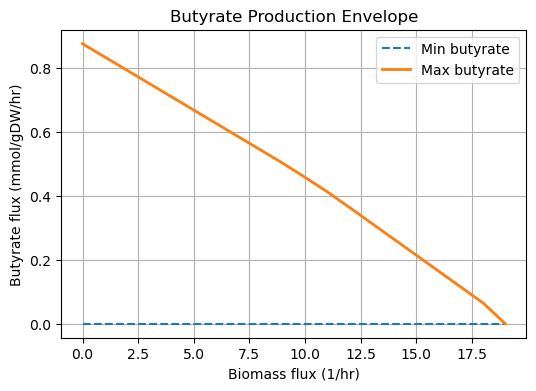


ATP / NADH balance at optimal biomass:
Net ATP (positive = net production): -0.0000
Net NADH (positive = net production): -0.0000
ATPM flux = 6.8600

Done.


In [16]:
from cobra.flux_analysis import production_envelope


# --------------------------------------------------------
# 1) FIND BIOMASS REACTION
# --------------------------------------------------------
def find_biomass_rxn(m):
    for r in m.reactions:
        if "biomass" in r.id.lower() or "biomass" in r.name.lower():
            return r
    raise RuntimeError("Biomass reaction not found — set model.objective manually.")

biomass_rxn = find_biomass_rxn(model)
model.objective = biomass_rxn


# --------------------------------------------------------
# 2) PRODUCTION ENVELOPE (biomass vs butyrate)
# --------------------------------------------------------
print("Computing production envelope...")

env = production_envelope(
    model,
    reactions=["EX_but_e"],      # use correct keyword for your COBRA version
    objective=biomass_rxn,       # pass reaction object
    points=20
)

# always convert to DataFrame
env = pd.DataFrame(env)


# --------------------------------------------------------
# 3) PLOT ENVELOPE
# --------------------------------------------------------
biomass_flux = env.index.values  # or np.linspace(0, max_growth, points) depending on your version

plt.figure(figsize=(6,4))
plt.plot(biomass_flux, env["flux_minimum"], "--", label="Min butyrate")
plt.plot(biomass_flux, env["flux_maximum"], label="Max butyrate", linewidth=2)

plt.xlabel("Biomass flux (1/hr)")
plt.ylabel("Butyrate flux (mmol/gDW/hr)")
plt.title("Butyrate Production Envelope")
plt.grid(True)
plt.legend()
plt.show()


# --------------------------------------------------------
# 4) ATP / NADH BALANCE
# --------------------------------------------------------
def net_cofactor_flux(solution, met_id):
    """Compute net (stoich * flux) for a metabolite in a FluxSolution."""
    total = 0.0
    for rxn_id, flux in solution.fluxes.items():
        if abs(flux) < 1e-9:
            continue
        rxn = model.reactions.get_by_id(rxn_id)
        for met, coeff in rxn.metabolites.items():
            if met.id == met_id:
                total += coeff * flux
    return total


print("\nATP / NADH balance at optimal biomass:")

model.objective = biomass_rxn
sol_now = model.optimize()

net_atp = net_cofactor_flux(sol_now, "atp_c")
net_nadh = net_cofactor_flux(sol_now, "nadh_c")

print(f"Net ATP (positive = net production): {net_atp:.4f}")
print(f"Net NADH (positive = net production): {net_nadh:.4f}")

for rid in ["ATPM", "ATPM_maintenance", "ATPS4r"]:
    if rid in model.reactions:
        print(f"{rid} flux = {sol_now.fluxes[rid]:.4f}")

print("\nDone.")
